In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras import backend as K 
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Notebook run using keras: 2.0.9


In [2]:
inet_model = inc_net.InceptionV3()

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [4]:
image_path = "./strawberry.jpg"

[('n07745940', 'strawberry', 0.91537607), ('n07836838', 'chocolate_sauce', 0.029392209), ('n07613480', 'trifle', 0.0027475634), ('n07614500', 'ice_cream', 0.001208978), ('n03124043', 'cowboy_boot', 0.001104438)]


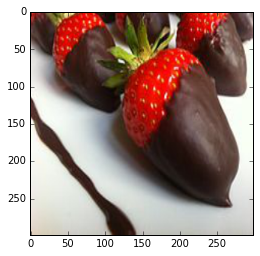

In [5]:
images = transform_img_fn([image_path])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds):
    print(x)

## Lime

In [6]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [7]:
img = transform_img_fn([image_path])[0]

In [8]:
explainer = lime_image.LimeImageExplainer()

In [9]:
%%time
explanation_img = explainer.explain_instance(img, inet_model.predict, top_labels=5, hide_color=0, num_samples=200)

CPU times: user 5min 50s, sys: 32 s, total: 6min 22s
Wall time: 2min 19s


### Labels

949 corresponds to the imagenet label for "strawberry."

You can replace 949 with the labels for 'chocolate sauce', 'trifle', etc. You can look up the numbers that correspond to those labels at https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a.

In [10]:
from skimage.segmentation import mark_boundaries

In [11]:
label_img = 949

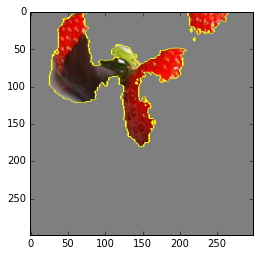

In [14]:
temp, mask = explanation_img.get_image_and_mask(label_img, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

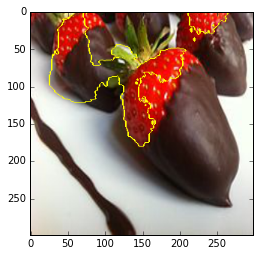

In [15]:
temp, mask = explanation_img.get_image_and_mask(label_img, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))